In [1]:
# import all relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge, ElasticNetCV, RidgeCV, LassoCV, LassoLars
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from scipy.interpolate import make_interp_spline
import datetime

In [2]:
charging = pd.read_csv("../charging_sessions.csv", encoding = "ISO-8859-1")
weather = pd.read_csv("../weather_burbank_airport.csv", encoding = "ISO-8859-1")

In [3]:
charging['connectionTime'] = pd.to_datetime(charging['connectionTime'])
charging['disconnectTime'] = pd.to_datetime(charging['disconnectTime'])

charging['connectionTime'] = charging['connectionTime'].dt.tz_localize(None)
charging['disconnectTime'] = charging['disconnectTime'].dt.tz_localize(None)

charging = charging[~charging['id'].duplicated(keep=False)]

charging = charging.drop(columns=['Unnamed: 0', 'doneChargingTime', 'kWhDelivered', 'sessionID', 'spaceID', 'timezone', 'userID', 'userInputs'])

site_a = charging[charging["siteID"] == 1]
site_b = charging[charging["siteID"] == 2]

In [4]:
unique_spaces_a = site_a["stationID"].nunique()
unique_spaces_b = site_b["stationID"].nunique()

print(unique_spaces_a)
print(unique_spaces_b)

52
55


In [5]:
def create_utilization_demo(df) -> pd.DataFrame:
    result = []

    # Filter unique days to include only those with at least one connection or disconnection
    relevant_days = pd.date_range(
        start=df['connectionTime'].dt.date.min(), 
        end=df['disconnectTime'].dt.date.max()
    )
    relevant_days = [
        day for day in relevant_days 
        if ((df['connectionTime'].dt.date <= day.date()) & (df['disconnectTime'].dt.date >= day.date())).any()
    ]

    # Iterate through each relevant day
    for day in relevant_days:
        # Generate hourly time slots for the day
        time_slots = pd.date_range(start=day, periods=24, freq='H')
        for time in time_slots:
            # Count the number of cars parked during this hour
            utilization = np.sum((df['connectionTime'] <= time) & (df['disconnectTime'] > time))
            result.append({'time': time, 'utilization': utilization})

    # Convert the result list to a dataframe
    return pd.DataFrame(result)

# Example usage:
utilization_demo_a = create_utilization_demo(site_a)
utilization_demo_b = create_utilization_demo(site_b)

C:\Users\vigro\AppData\Local\Temp\ipykernel_23868\4067825312.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_slots = pd.date_range(start=day, periods=24, freq='H')


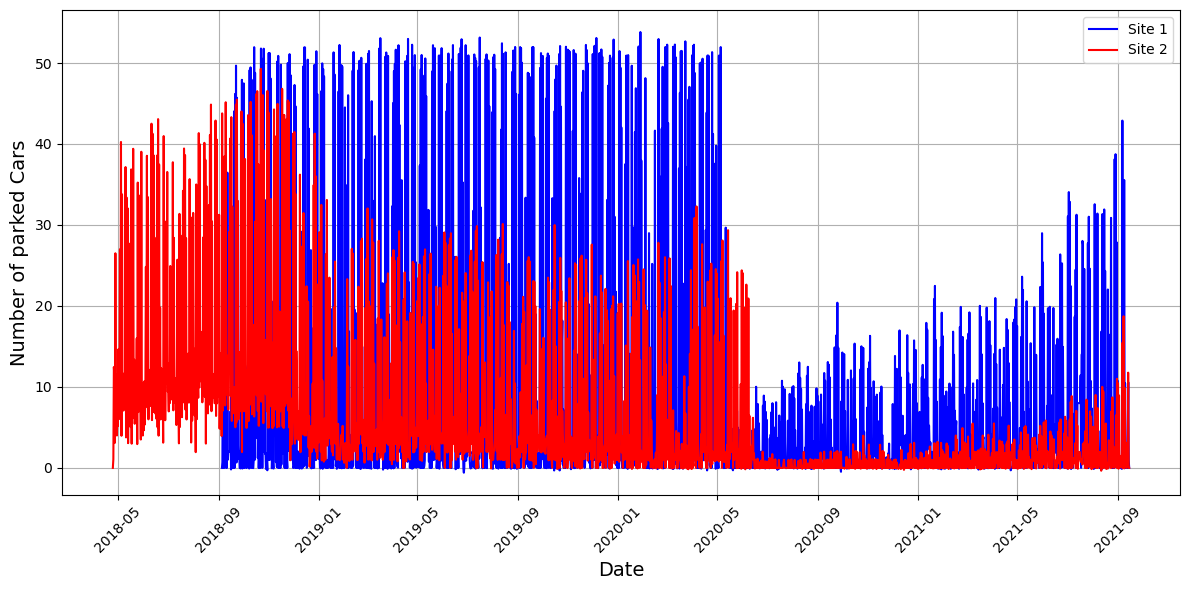

In [6]:
def smooth_curve(dataframe):

    x = np.arange(len(dataframe))  # Numeric representation of time
    y = dataframe['utilization'].values

    # Create a spline interpolation
    spline = make_interp_spline(x, y, k=3)  # Cubic spline interpolation
    x_smooth = np.linspace(x.min(), x.max(), 2000)  # Increase resolution for smoother curve
    y_smooth = spline(x_smooth)

    # Match time array to the interpolated points
    time_smooth = np.linspace(dataframe['time'].iloc[0].timestamp(), 
                              dataframe['time'].iloc[-1].timestamp(), 
                              len(x_smooth))
    time_smooth = pd.to_datetime(time_smooth, unit='s')
    return time_smooth, y_smooth

# Smooth curves for both sites
time_smooth_a, y_smooth_a = smooth_curve(utilization_demo_a)
time_smooth_b, y_smooth_b = smooth_curve(utilization_demo_b)

# Plot the utilization for both sites
plt.figure(figsize=(12, 6))
plt.plot(time_smooth_a, y_smooth_a, color='b', label='Site 1')
plt.plot(time_smooth_b, y_smooth_b, color='r', label='Site 2')

# Formatting the plot

plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of parked Cars', fontsize=14)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

In [7]:
def preprocess_weather_data(weather_df: pd.DataFrame) -> pd.DataFrame:

    # Convert timestamp to datetime and set it as the index
    weather_df['timestamp'] = pd.to_datetime(weather_df['timestamp'])
    weather_df.set_index('timestamp', inplace=True)
    
    # Resample to hourly frequency and interpolate missing values
    weather_resampled = weather_df.resample('H').interpolate(method='linear')
    
    return weather_resampled

In [8]:
def create_utilization(df, start_date, end_date, weather_resampled) -> pd.DataFrame:
    result = []
    
    # Ensure connectionTime and disconnectTime are datetime types
    if not df.empty:
        df['connectionTime'] = pd.to_datetime(df['connectionTime'])
        df['disconnectTime'] = pd.to_datetime(df['disconnectTime'])
    
    # Define the date range based on input parameters
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    # Handle the case where df is empty or all data is out of the date range
    if df.empty or df['connectionTime'].max() < start_date or df['disconnectTime'].min() > end_date:
        print(f"No data available in the specified date range: {start_date} to {end_date}")
        return pd.DataFrame(result)  # Return an empty DataFrame
    
    # Filter relevant days within the provided date range
    relevant_days = pd.date_range(
        start=max(df['connectionTime'].dt.date.min(), start_date.date()), 
        end=min(df['disconnectTime'].dt.date.max(), end_date.date())
    )
    relevant_days = [
        day for day in relevant_days 
        if ((df['connectionTime'].dt.date <= day.date()) & (df['disconnectTime'].dt.date >= day.date())).any()
    ]
    
    if not relevant_days:
        print("No relevant days found in the date range.")
        return pd.DataFrame(result)  # Return an empty DataFrame

    # Iterate through each relevant day
    for day in relevant_days:
        # Generate hourly time slots for the day
        time_slots = pd.date_range(start=day, periods=24, freq='H')
        
        for time in time_slots:
            # Count the number of cars parked during this hour
            utilization = np.sum((df['connectionTime'] <= time) & (df['disconnectTime'] > time))
            
            # Get temperature at the current time, using .loc[] to index by timestamp
            temperature = np.nan  # Default to NaN if not found
            if time in weather_resampled.index:
                temperature = weather_resampled.loc[time, 'temperature']
            
            result.append({
                'time': time.hour,
                'utilization': utilization,
                'month': day.month,
                'isWeekday': day.weekday() < 5,
                'isMonday': day.weekday() == 0,
                'isTuesday': day.weekday() == 1,
                'isWednesday': day.weekday() == 2,
                'isThursday': day.weekday() == 3,
                'isFriday': day.weekday() == 4,
                'isSaturday': day.weekday() == 5,
                'isSunday': day.weekday() == 6,
                'temperature': temperature  # Add temperature to the result
            })
    
    # Convert the result list to a dataframe
    return pd.DataFrame(result)




In [9]:
# Preprocess the weather data
weather_resampled = preprocess_weather_data(weather)

# Generate utilization DataFrames
utilization_a = create_utilization(site_a, '2018-09-01', '2020-04-01', weather_resampled)
utilization_b = create_utilization(site_b, '2018-05-01', '2020-04-01', weather_resampled)

# Inspect results

C:\Users\vigro\AppData\Local\Temp\ipykernel_23868\4230897155.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  weather_resampled = weather_df.resample('H').interpolate(method='linear')
C:\Users\vigro\AppData\Local\Temp\ipykernel_23868\4230897155.py:8: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  weather_resampled = weather_df.resample('H').interpolate(method='linear')
C:\Users\vigro\AppData\Local\Temp\ipykernel_23868\3819350747.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['connectionTime'] = pd.to_datetime(df['connectionTime'])
C:\Users\vigro\AppData\Local\

In [10]:
def compute_column_importance(df, target_column):
        # Drop any categorical columns (non-numeric columns) except the target column
        df = df.select_dtypes(exclude=['object', 'category'])  # This excludes object-type (categorical) columns
        
        # Separate features (X) and target (y)
        X = df.drop(columns=[target_column])
        y = df[target_column]
        
        # Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
        
        # Train a Random Forest Regressor
        model = RandomForestRegressor(random_state=42)
        model.fit(X_train, y_train)
        
        # Compute feature importance (from Random Forest)
        feature_importances = model.feature_importances_
        feature_importance_df = pd.DataFrame({
            'Feature': X.columns,
            'Importance': feature_importances
        }).sort_values(by='Importance', ascending=False)
        
        # Optional: Compute permutation importance for a second view
        perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
        perm_importance_df = pd.DataFrame({
            'Feature': X.columns,
            'Permutation Importance': perm_importance.importances_mean
        }).sort_values(by='Permutation Importance', ascending=False)
        
        return feature_importance_df, perm_importance_df

feature_importance_df_a, perm_importance_df_a = compute_column_importance(utilization_a, "utilization")
feature_importance_df_b, perm_importance_df_b = compute_column_importance(utilization_b, "utilization")

In [11]:
pd.set_option('display.max_rows', None)  # Show all rows    
pd.set_option('display.max_columns', None)  # Show all columns if needed
pd.set_option('display.width', None)  # Avoid line wrapping
pd.set_option('display.float_format', '{:.6f}'.format)  # Show floats in standard format
    
print(feature_importance_df_a)
print(feature_importance_df_b)

pd.reset_option('display.max_rows')

        Feature  Importance
0          time    0.472511
2     isWeekday    0.299892
10  temperature    0.129791
1         month    0.037415
7      isFriday    0.024727
3      isMonday    0.016573
9      isSunday    0.005757
5   isWednesday    0.004364
4     isTuesday    0.004289
6    isThursday    0.003602
8    isSaturday    0.001078
        Feature  Importance
0          time    0.452281
10  temperature    0.213676
2     isWeekday    0.191338
1         month    0.075809
3      isMonday    0.022319
9      isSunday    0.015035
4     isTuesday    0.007997
5   isWednesday    0.007061
7      isFriday    0.006569
6    isThursday    0.006063
8    isSaturday    0.001853


C:\Users\vigro\AppData\Local\Temp\ipykernel_23868\48318911.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='time', y='utilization', data=weekday_data, palette='Blues', ax=axes[0])
C:\Users\vigro\AppData\Local\Temp\ipykernel_23868\48318911.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='time', y='utilization', data=weekend_data, palette='Blues', ax=axes[1])


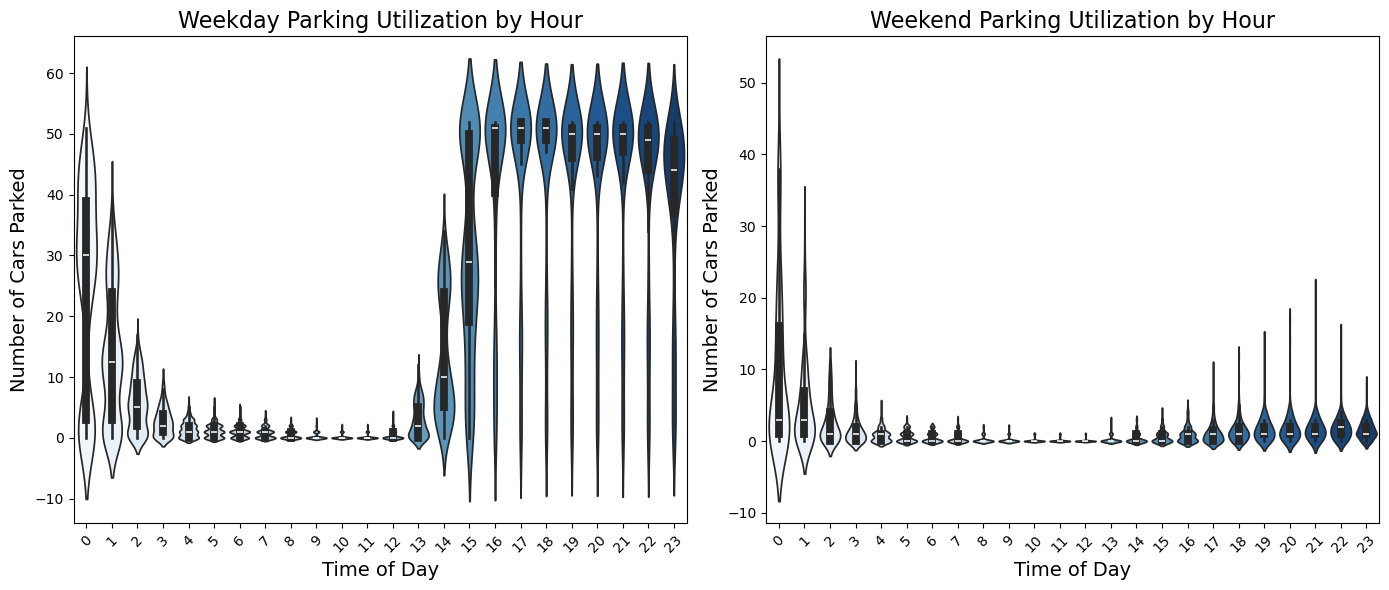

In [12]:
# Filter the data based on isWeekday
weekday_data = utilization_a[utilization_a['isWeekday'] == 1]
weekend_data = utilization_a[utilization_a['isWeekday'] == 0]

# Set up the figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for weekdays (isWeekday = 1)
sns.violinplot(x='time', y='utilization', data=weekday_data, palette='Blues', ax=axes[0])
axes[0].set_title('Weekday Parking Utilization by Hour', fontsize=16)
axes[0].set_xlabel('Time of Day', fontsize=14)
axes[0].set_ylabel('Number of Cars Parked', fontsize=14)
axes[0].tick_params(axis='x', rotation=45)

# Plot for weekends (isWeekday = 0)
sns.violinplot(x='time', y='utilization', data=weekend_data, palette='Blues', ax=axes[1])
axes[1].set_title('Weekend Parking Utilization by Hour', fontsize=16)
axes[1].set_xlabel('Time of Day', fontsize=14)
axes[1].set_ylabel('Number of Cars Parked', fontsize=14)
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

polynomial regression

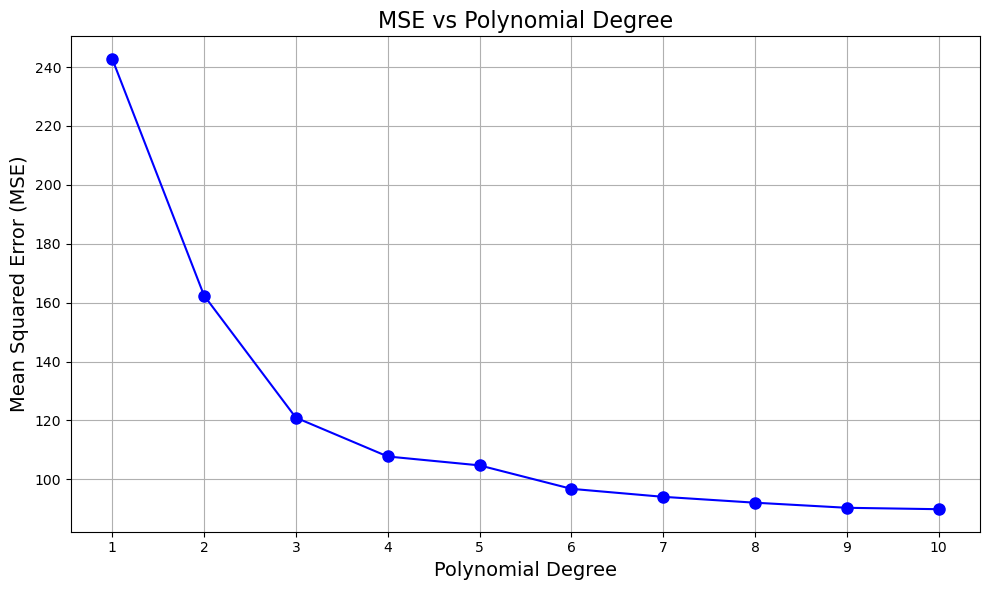

In [13]:
x_a_time = utilization_a["time"].values.reshape(-1, 1)
x_a_isWeekday = utilization_a["isWeekday"].astype(int).values.reshape(-1, 1)  # Convert boolean to int (0 or 1)

# Combine both features into a single feature matrix
x_a = np.hstack([x_a_time, x_a_isWeekday])
y_a = utilization_a["utilization"]

mse_values = []

# Loop through polynomial degrees from 1 to 10
for poly_degree in range(1, 11):
    # Transform the feature matrix to include polynomial terms
    poly = PolynomialFeatures(degree=poly_degree, include_bias=False)
    x_a_poly = poly.fit_transform(x_a)  # Transform data to include polynomial features

    # Split the data into training and testing sets
    x_a_train, x_a_test, y_a_train, y_a_test = train_test_split(x_a_poly, y_a, test_size=0.5, random_state=42)

    # Create and fit the Linear Regression model
    model = LinearRegression()
    model.fit(x_a_train, y_a_train)

    # Make predictions
    y_a_pred = model.predict(x_a_test)

    # Calculate the MSE for this degree
    mse = mean_squared_error(y_a_test, y_a_pred)
    mse_values.append(mse)

# Plot MSE values for each degree of polynomial
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), mse_values, marker='o', color='b', linestyle='-', markersize=8)
plt.title('MSE vs Polynomial Degree', fontsize=16)
plt.xlabel('Polynomial Degree', fontsize=14)
plt.ylabel('Mean Squared Error (MSE)', fontsize=14)
plt.grid(True)
plt.xticks(range(1, 11))  # To ensure all degrees are labeled on the x-axis
plt.tight_layout()
plt.show()



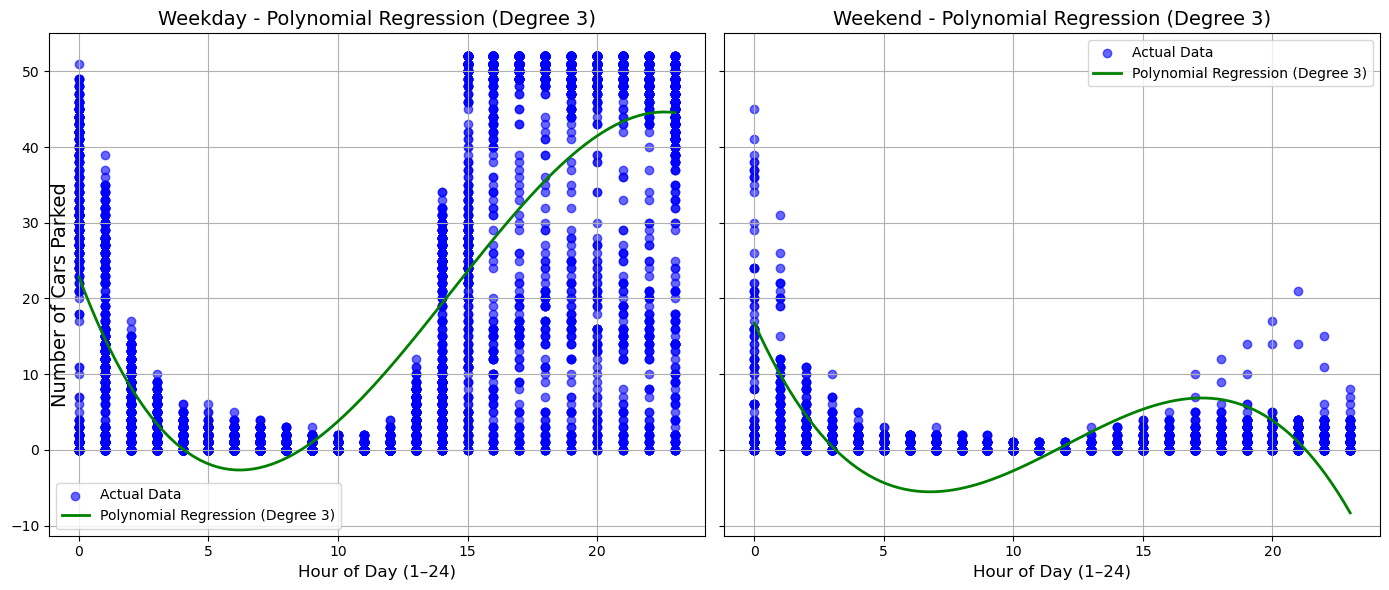

In [14]:
x_a_train, x_a_test, y_a_train, y_a_test = train_test_split(x_a, y_a, test_size=0.5, random_state=42)

# Create polynomial features with degree 3
poly = PolynomialFeatures(degree=3)

# Transform the Hour and isWeekday features together
x_train_poly = poly.fit_transform(x_a_train)  # Polynomial transform for both features
x_test_poly = poly.transform(x_a_test)  # Apply the same transformation to the test set

model_a_poly = LinearRegression()
model_a_poly.fit(x_train_poly, y_a_train)

# Predictions for smooth curve
X_grid = np.linspace(min(x_a[:, 0]), max(x_a[:, 0]), 100).reshape(-1, 1)

# Create a combined feature array where isWeekday is set to 1 for weekdays and 0 for weekends
X_grid_weekday = np.hstack([X_grid, np.ones_like(X_grid)])  # Set isWeekday to 1 (weekday)
X_grid_weekend = np.hstack([X_grid, np.zeros_like(X_grid)])  # Set isWeekday to 0 (weekend)

X_grid_poly_weekday = poly.transform(X_grid_weekday)  # Apply polynomial transformation
X_grid_poly_weekend = poly.transform(X_grid_weekend)

y_grid_weekday = model_a_poly.predict(X_grid_poly_weekday)  # Predictions for weekdays
y_grid_weekend = model_a_poly.predict(X_grid_poly_weekend)  # Predictions for weekends

# Subplots for weekday and weekend
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for ax, title, is_weekday, y_grid in zip(axes,
    ["Weekday", "Weekend"],
    [1, 0],
    [y_grid_weekday, y_grid_weekend]):
    
    # Filter data for weekday or weekend
    x_data = x_a[x_a[:, 1] == is_weekday]
    y_data = y_a[x_a[:, 1] == is_weekday]

    # Scatter plot of actual data
    ax.scatter(x_data[:, 0], y_data, color='blue', label='Actual Data', alpha=0.6)

    # Polynomial regression line
    ax.plot(X_grid, y_grid, color='green', label='Polynomial Regression (Degree 3)', linewidth=2)

    # Titles and labels
    ax.set_title(f'{title} - Polynomial Regression (Degree 3)', fontsize=14)
    ax.set_xlabel('Hour of Day (1–24)', fontsize=12)
    ax.grid(True)
    ax.legend()

# Shared y-label
fig.text(0.04, 0.5, 'Number of Cars Parked', va='center', rotation='vertical', fontsize=14)

plt.tight_layout()
plt.show()



RandomForestRegressor

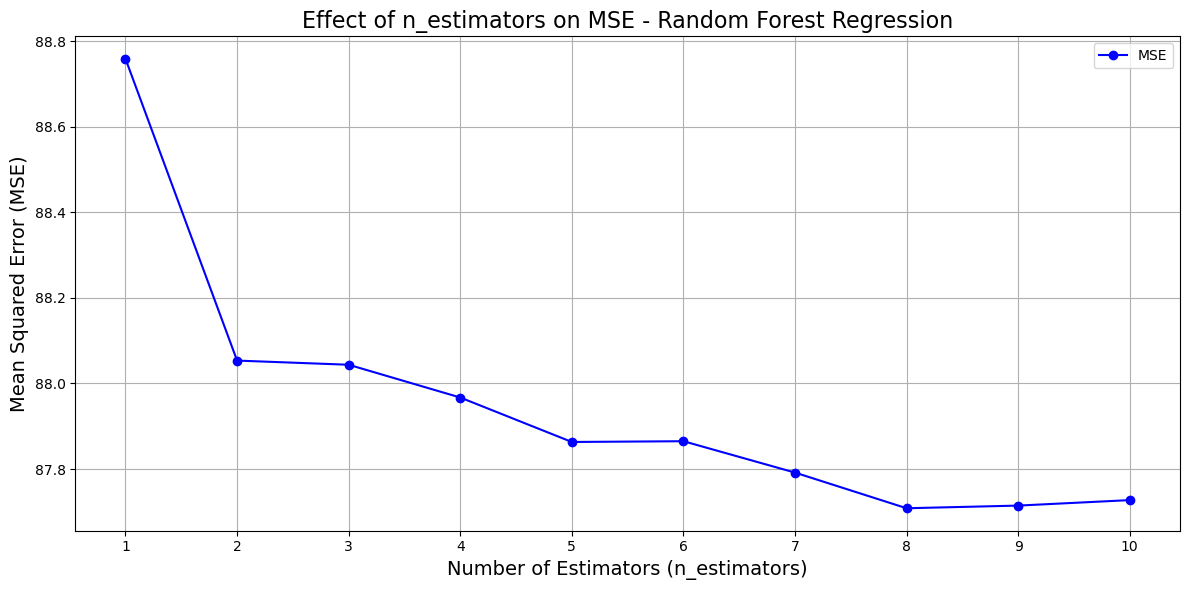

In [15]:
# Split the data into training and testing sets
x_a_train, x_a_test, y_a_train, y_a_test = train_test_split(x_a, y_a, test_size=0.5, random_state=42)

# Initialize lists to store the results
n_estimators_range = range(1, 11, 1)
mse_values = []

# Loop through the range of n_estimators
for n_estimators in n_estimators_range:
    # Create and fit the RandomForestRegressor model
    model_a_rf = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
    model_a_rf.fit(x_a_train, y_a_train)
    
    # Make predictions
    y_a_pred = model_a_rf.predict(x_a_test)
    
    # Calculate Mean Squared Error
    mse = mean_squared_error(y_a_test, y_a_pred)
    mse_values.append(mse)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(n_estimators_range, mse_values, marker='o', linestyle='-', color='blue', label='MSE')
plt.title('Effect of n_estimators on MSE - Random Forest Regression', fontsize=16)
plt.xlabel('Number of Estimators (n_estimators)', fontsize=14)
plt.ylabel('Mean Squared Error (MSE)', fontsize=14)
plt.xticks(n_estimators_range)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

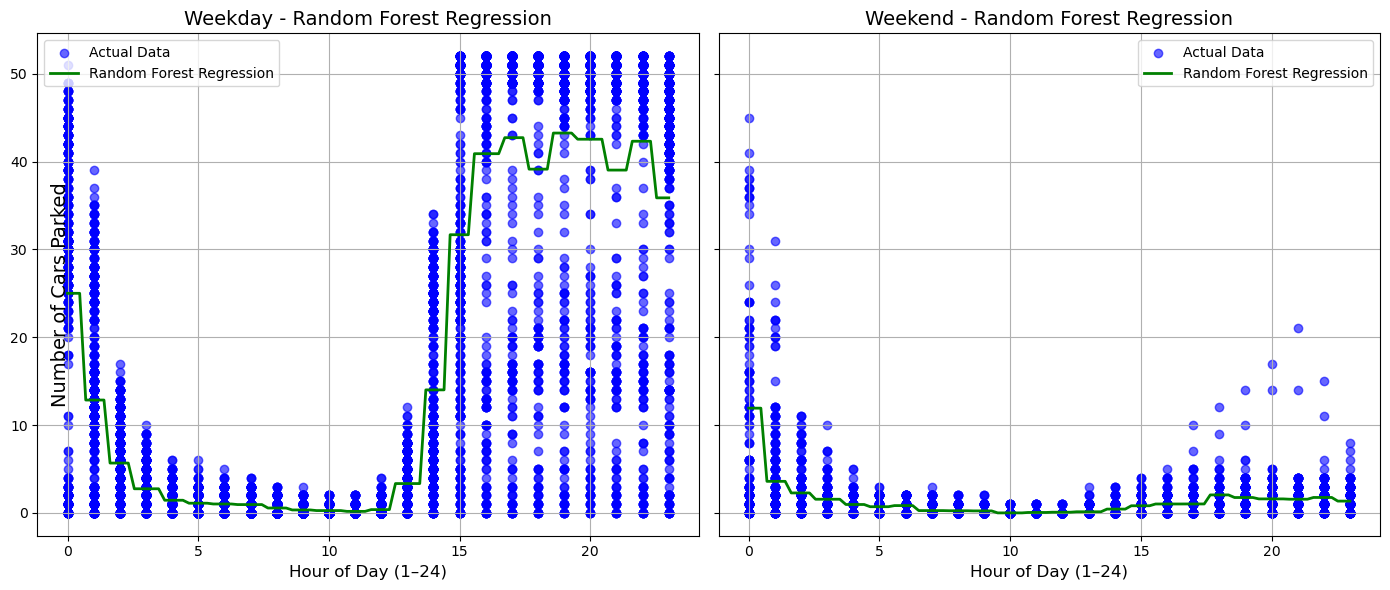

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x_a, y_a, test_size=0.5, random_state=42)

# Train a single Random Forest model with both features (Hour and isWeekday)
model_a_rf = RandomForestRegressor(n_estimators=1, random_state=42)  # You can adjust n_estimators as needed
model_a_rf.fit(x_train, y_train)

# Predictions for smooth curve
X_grid = np.linspace(min(x_a[:, 0]), max(x_a[:, 0]), 100).reshape(-1, 1)
X_grid_combined = np.hstack([X_grid, np.ones_like(X_grid) * x_a[0, 1]])  # Add the isWeekday feature
y_grid = model_a_rf.predict(X_grid_combined)

# Subplots for weekday and weekend
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for ax, title, is_weekday in zip(axes, ["Weekday", "Weekend"], [1, 0]):
    # Filter data for weekday or weekend
    x_data = x_a[x_a[:, 1] == is_weekday]
    y_data = y_a[x_a[:, 1] == is_weekday]

    # Scatter plot of actual data
    ax.scatter(x_data[:, 0], y_data, color='blue', label='Actual Data', alpha=0.6)

    # Random Forest regression line
    X_grid_combined = np.hstack([X_grid, np.ones_like(X_grid) * is_weekday])  # Update for weekday/weekend
    y_grid = model_a_rf.predict(X_grid_combined)
    ax.plot(X_grid, y_grid, color='green', label='Random Forest Regression', linewidth=2)

    # Titles and labels
    ax.set_title(f'{title} - Random Forest Regression', fontsize=14)
    ax.set_xlabel('Hour of Day (1–24)', fontsize=12)
    ax.grid(True)
    ax.legend()

# Shared y-label
fig.text(0.04, 0.5, 'Number of Cars Parked', va='center', rotation='vertical', fontsize=14)

plt.tight_layout()
plt.show()

neural network

4/4 [==============================] - 0s 3ms/step


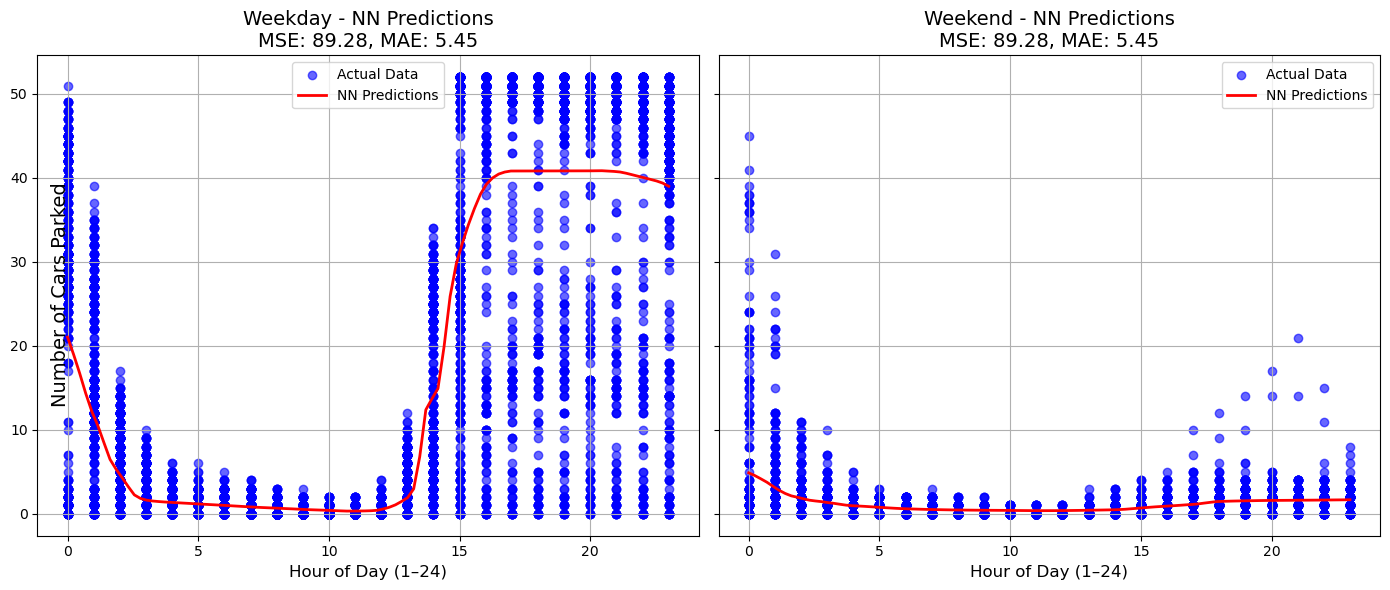

In [17]:
def build_and_train_nn(x_data, y_data):
    # Standardize the features: scale both 'time' and 'isWeekday'
    scaler = StandardScaler()
    x_data_scaled = scaler.fit_transform(x_data)  # Scale both features together

    # Split data into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(x_data_scaled, y_data, test_size=0.5, random_state=42)

    # Build the neural network model
    model = Sequential()
    model.add(Dense(512, input_dim=2, activation='relu'))  # Input layer and first hidden layer (2 features)
    model.add(Dropout(0.3))  # Dropout layer
    model.add(Dense(256, activation='relu'))  # Second hidden layer
    model.add(Dropout(0.3))  # Dropout layer
    model.add(Dense(128, activation='relu'))  # Third hidden layer
    model.add(Dropout(0.3))  # Dropout layer
    model.add(Dense(64, activation='relu'))  # Fourth hidden layer
    model.add(Dense(1, activation='linear'))  # Output layer

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

    # Train the model
    model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test), verbose=0)

    # Evaluate the model
    test_loss, test_mae = model.evaluate(x_test, y_test, verbose=0)

    # Predictions for smooth grid
    X_grid = np.linspace(min(x_data[:, 0]), max(x_data[:, 0]), 100).reshape(-1, 1)
    X_grid_combined = np.hstack([X_grid, np.ones_like(X_grid) * x_data[0, 1]])  # Combine time and 'isWeekday' for predictions
    X_grid_scaled = scaler.transform(X_grid_combined)  # Scale both features together
    y_grid = model.predict(X_grid_scaled)

    return X_grid, y_grid, test_loss, test_mae, model, scaler

# Train the model on the combined data
X_grid, y_grid, test_loss, test_mae, model_a_neuro, scaler = build_and_train_nn(x_a, y_a)

# Subplots for weekday and weekend
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for ax, title, is_weekday in zip(
    axes, 
    ["Weekday", "Weekend"],
    [1, 0]
):
    x_data = x_a[x_a[:, 1] == is_weekday]
    y_data = y_a[x_a[:, 1] == is_weekday]
    # Scatter plot of actual data
    ax.scatter(x_data[:, 0], y_data, color='blue', label='Actual Data', alpha=0.6)

    # Prepare the grid for predictions
    X_grid_combined = np.hstack([X_grid, np.ones_like(X_grid) * x_data[0, 1]])  # Keep isWeekday value for the current subset
    X_grid_scaled = scaler.transform(X_grid_combined)  # Scale both time and isWeekday features
    
    # Make predictions for the smooth grid
    y_grid = model_a_neuro.predict(X_grid_scaled)
    
    # Plot the neural network predictions
    ax.plot(X_grid[:, 0], y_grid, color='red', label='NN Predictions', linewidth=2)

    # Titles and labels
    ax.set_title(f'{title} - NN Predictions\nMSE: {test_loss:.2f}, MAE: {test_mae:.2f}', fontsize=14)
    ax.set_xlabel('Hour of Day (1–24)', fontsize=12)
    ax.grid(True)
    ax.legend()

# Shared y-label
fig.text(0.04, 0.5, 'Number of Cars Parked', va='center', rotation='vertical', fontsize=14)

plt.tight_layout()
plt.show()

4/4 [==============================] - 0s 2ms/step


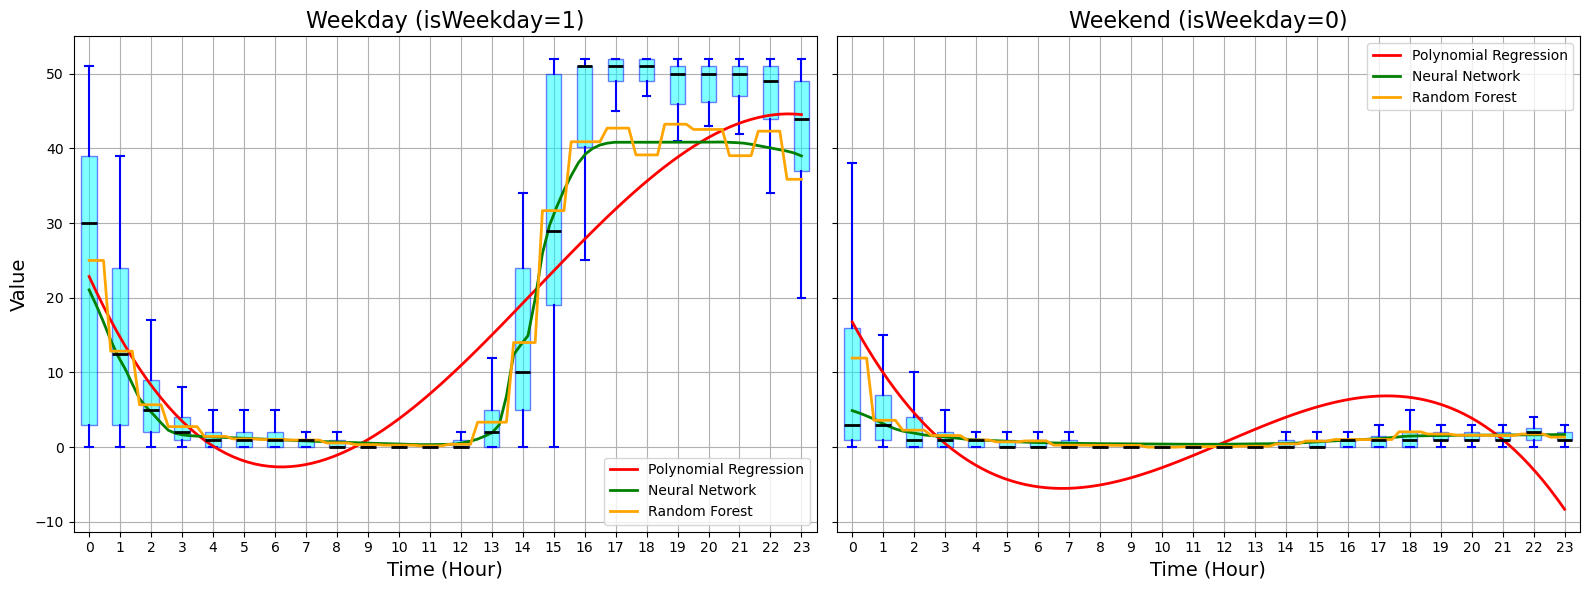

In [18]:
# Split data into weekday (isWeekday=1) and weekend (isWeekday=0)
x_weekday = x_a[x_a[:, 1] == 1]
y_weekday = y_a[x_a[:, 1] == 1]
x_weekend = x_a[x_a[:, 1] == 0]
y_weekend = y_a[x_a[:, 1] == 0]

# Create smooth grids for prediction with the addition of the isWeekday feature
time_grid_weekday = np.linspace(min(x_weekday[:, 0]), max(x_weekday[:, 0]), 100).reshape(-1, 1)
X_grid_weekday = np.hstack([time_grid_weekday, np.ones_like(time_grid_weekday)])  # Add isWeekday=1

time_grid_weekend = np.linspace(min(x_weekend[:, 0]), max(x_weekend[:, 0]), 100).reshape(-1, 1)
X_grid_weekend = np.hstack([time_grid_weekend, np.zeros_like(time_grid_weekend)])  # Add isWeekday=0

# Ensure the correct shape
X_grid_weekday_neuro = np.hstack([time_grid_weekday, np.ones_like(time_grid_weekday)])  # (100, 2)
X_grid_weekend_neuro = np.hstack([time_grid_weekend, np.zeros_like(time_grid_weekend)])  # (100, 2)

# If feature scaling was used during training, apply the same scaling
X_grid_weekday_scaled_neuro = scaler.transform(X_grid_weekday)  # Use the same scaler as during training
X_grid_weekend_scaled_neuro = scaler.transform(X_grid_weekend)

# Predict using the correctly transformed inputs
y_grid_neuro_weekday = model_a_neuro.predict(X_grid_weekday_scaled_neuro)
y_grid_neuro_weekend = model_a_neuro.predict(X_grid_weekend_scaled_neuro)


# Predictions for weekday
y_grid_poly_weekday = model_a_poly.predict(poly.transform(X_grid_weekday))
y_grid_rf_weekday = model_a_rf.predict(X_grid_weekday)

# Predictions for weekend
y_grid_poly_weekend = model_a_poly.predict(poly.transform(X_grid_weekend))
y_grid_rf_weekend = model_a_rf.predict(X_grid_weekend)

# Create the plots
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Weekday boxplot and predictions
unique_hours_weekday = np.unique(x_weekday[:, 0])
data_for_boxplot_weekday = [y_weekday[x_weekday[:, 0] == hour] for hour in unique_hours_weekday]

axs[0].boxplot(
    data_for_boxplot_weekday,
    positions=unique_hours_weekday,
    widths=0.5,
    patch_artist=True,
    boxprops=dict(facecolor='cyan', color='blue', alpha=0.5),
    medianprops=dict(color='black', linewidth=2),
    whiskerprops=dict(color='blue', linewidth=1.5),
    capprops=dict(color='blue', linewidth=1.5),
    showfliers=False,
)
axs[0].plot(X_grid_weekday[:, 0], y_grid_poly_weekday, color='red', label='Polynomial Regression', linewidth=2)
axs[0].plot(X_grid_weekday[:, 0], y_grid_neuro_weekday, color='green', label='Neural Network', linewidth=2)
axs[0].plot(X_grid_weekday[:, 0], y_grid_rf_weekday, color='orange', label='Random Forest', linewidth=2)
axs[0].set_title('Weekday (isWeekday=1)', fontsize=16)
axs[0].set_xlabel('Time (Hour)', fontsize=14)
axs[0].set_ylabel('Value', fontsize=14)
axs[0].grid(True)
axs[0].legend()

# Weekend boxplot and predictions
unique_hours_weekend = np.unique(x_weekend[:, 0])
data_for_boxplot_weekend = [y_weekend[x_weekend[:, 0] == hour] for hour in unique_hours_weekend]

axs[1].boxplot(
    data_for_boxplot_weekend,
    positions=unique_hours_weekend,
    widths=0.5,
    patch_artist=True,
    boxprops=dict(facecolor='cyan', color='blue', alpha=0.5),
    medianprops=dict(color='black', linewidth=2),
    whiskerprops=dict(color='blue', linewidth=1.5),
    capprops=dict(color='blue', linewidth=1.5),
    showfliers=False,
)
axs[1].plot(X_grid_weekend[:, 0], y_grid_poly_weekend, color='red', label='Polynomial Regression', linewidth=2)
axs[1].plot(X_grid_weekend[:, 0], y_grid_neuro_weekend, color='green', label='Neural Network', linewidth=2)
axs[1].plot(X_grid_weekend[:, 0], y_grid_rf_weekend, color='orange', label='Random Forest', linewidth=2)
axs[1].set_title('Weekend (isWeekday=0)', fontsize=16)
axs[1].set_xlabel('Time (Hour)', fontsize=14)
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()

C:\Users\vigro\AppData\Local\Temp\ipykernel_23868\1462734283.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='time', y='utilization', data=weekday_data, palette='Blues', ax=axes[0])
C:\Users\vigro\AppData\Local\Temp\ipykernel_23868\1462734283.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='time', y='utilization', data=weekend_data, palette='Blues', ax=axes[1])


4/4 [==============================] - 0s 1ms/step


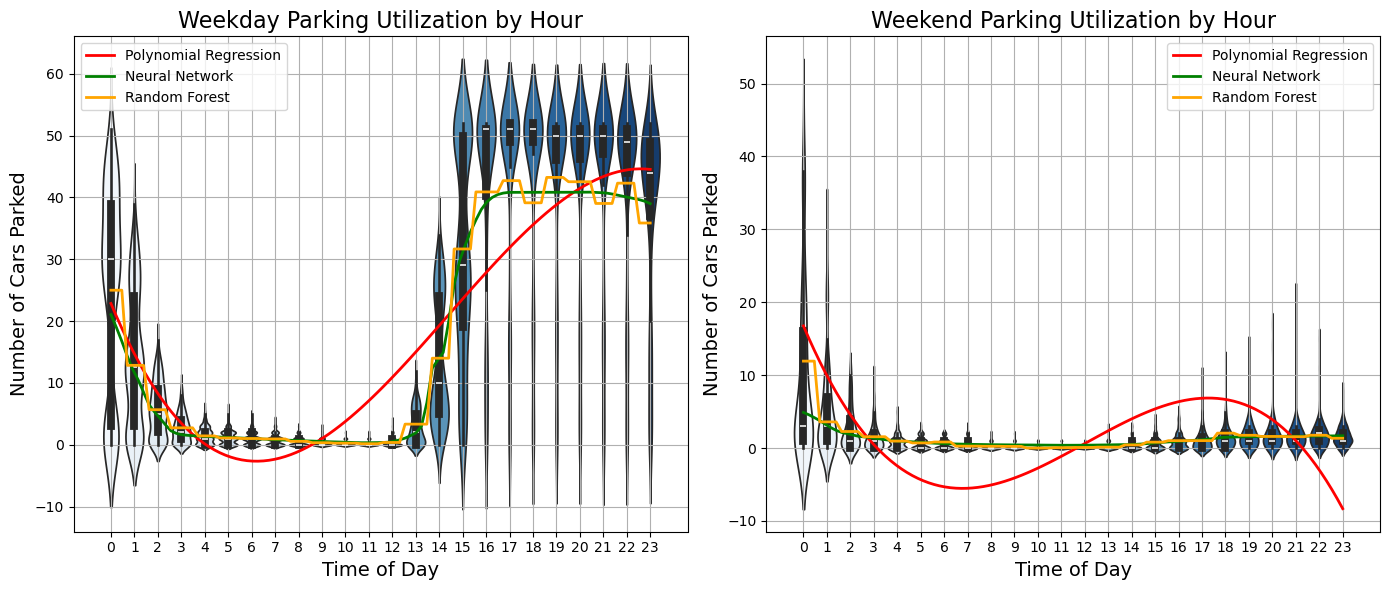

In [19]:
# Filter the data based on isWeekday
weekday_data = utilization_a[utilization_a['isWeekday'] == 1]
weekend_data = utilization_a[utilization_a['isWeekday'] == 0]

# Set up the figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot violin plots
sns.violinplot(x='time', y='utilization', data=weekday_data, palette='Blues', ax=axes[0])
sns.violinplot(x='time', y='utilization', data=weekend_data, palette='Blues', ax=axes[1])

# Generate smooth time values
time_range = np.linspace(0, 23, 100).reshape(-1, 1)  # Assuming time is in hours

# Prepare feature matrix for regression models
X_grid_weekday = np.hstack([time_range, np.ones_like(time_range)])  # [time, isWeekday=1]
X_grid_weekend = np.hstack([time_range, np.zeros_like(time_range)])  # [time, isWeekday=0]

# Apply transformations if necessary
X_grid_weekday_poly = poly.transform(X_grid_weekday)  # For polynomial model
X_grid_weekend_poly = poly.transform(X_grid_weekend)

# Make predictions
y_grid_poly_weekday = model_a_poly.predict(X_grid_weekday_poly)
y_grid_poly_weekend = model_a_poly.predict(X_grid_weekend_poly)

y_grid_neuro_weekday = model_a_neuro.predict(scaler.transform(X_grid_weekday))
y_grid_neuro_weekend = model_a_neuro.predict(scaler.transform(X_grid_weekend))

y_grid_rf_weekday = model_a_rf.predict(X_grid_weekday)
y_grid_rf_weekend = model_a_rf.predict(X_grid_weekend)

# Plot regression lines
axes[0].plot(time_range, y_grid_poly_weekday, color='red', label='Polynomial Regression', linewidth=2)
axes[0].plot(time_range, y_grid_neuro_weekday, color='green', label='Neural Network', linewidth=2)
axes[0].plot(time_range, y_grid_rf_weekday, color='orange', label='Random Forest', linewidth=2)

axes[1].plot(time_range, y_grid_poly_weekend, color='red', label='Polynomial Regression', linewidth=2)
axes[1].plot(time_range, y_grid_neuro_weekend, color='green', label='Neural Network', linewidth=2)
axes[1].plot(time_range, y_grid_rf_weekend, color='orange', label='Random Forest', linewidth=2)

# Set titles and labels
axes[0].set_title('Weekday Parking Utilization by Hour', fontsize=16)
axes[1].set_title('Weekend Parking Utilization by Hour', fontsize=16)
for ax in axes:
    ax.set_xlabel('Time of Day', fontsize=14)
    ax.set_ylabel('Number of Cars Parked', fontsize=14)
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


Site B

C:\Users\vigro\AppData\Local\Temp\ipykernel_23868\2937389958.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='time', y='utilization', data=weekday_data, palette='Blues', ax=axes[0])
C:\Users\vigro\AppData\Local\Temp\ipykernel_23868\2937389958.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='time', y='utilization', data=weekend_data, palette='Blues', ax=axes[1])


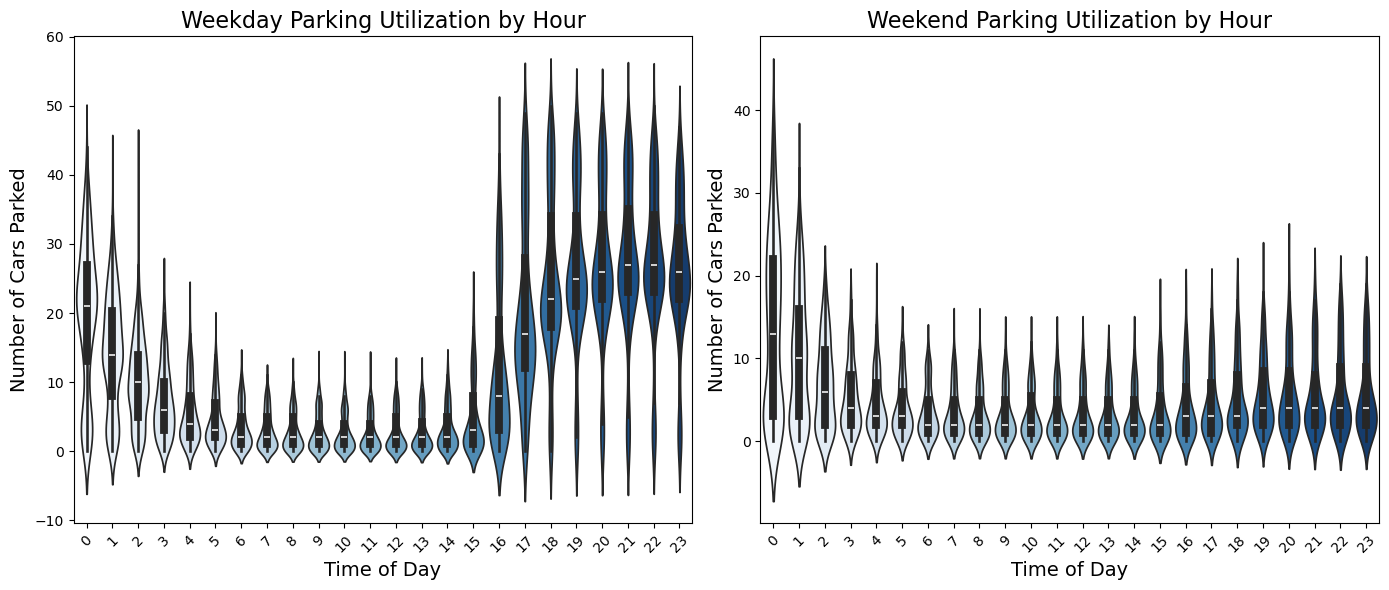

In [20]:
# Filter the data based on isWeekday
weekday_data = utilization_b[utilization_b['isWeekday'] == 1]
weekend_data = utilization_b[utilization_b['isWeekday'] == 0]

# Set up the figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for weekdays (isWeekday = 1)
sns.violinplot(x='time', y='utilization', data=weekday_data, palette='Blues', ax=axes[0])
axes[0].set_title('Weekday Parking Utilization by Hour', fontsize=16)
axes[0].set_xlabel('Time of Day', fontsize=14)
axes[0].set_ylabel('Number of Cars Parked', fontsize=14)
axes[0].tick_params(axis='x', rotation=45)

# Plot for weekends (isWeekday = 0)
sns.violinplot(x='time', y='utilization', data=weekend_data, palette='Blues', ax=axes[1])
axes[1].set_title('Weekend Parking Utilization by Hour', fontsize=16)
axes[1].set_xlabel('Time of Day', fontsize=14)
axes[1].set_ylabel('Number of Cars Parked', fontsize=14)
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

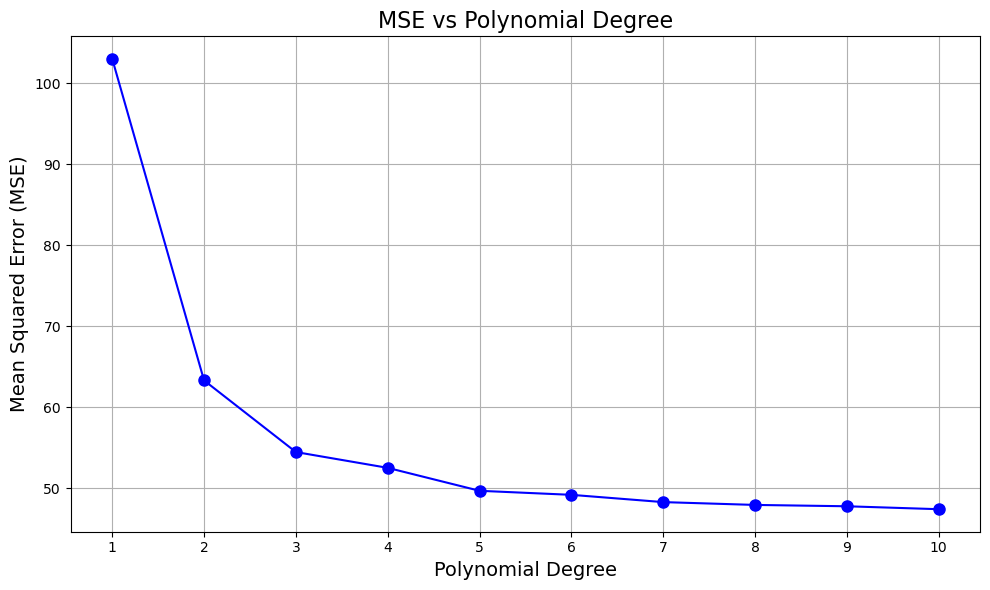

In [21]:
x_b_time = utilization_b["time"].values.reshape(-1, 1)
x_b_isWeekday = utilization_b["isWeekday"].astype(int).values.reshape(-1, 1)  # Convert boolean to int (0 or 1)

# Combine both features into a single feature matrix
x_b = np.hstack([x_b_time, x_b_isWeekday])
y_b = utilization_b["utilization"]
mse_values = []

# Loop through polynomial degrees from 1 to 10
for poly_degree in range(1, 11):
    # Transform the feature to include polynomial terms
    poly = PolynomialFeatures(degree=poly_degree)
    x_b_poly = poly.fit_transform(x_b)  # Transform the data to include polynomial features

    # Split the data into training and testing sets
    x_b_train, x_b_test, y_b_train, y_b_test = train_test_split(x_b_poly, y_b, test_size=0.5, random_state=42)

    # Create and fit the Linear Regression model
    model = LinearRegression()
    model.fit(x_b_train, y_b_train)

    # Make predictions
    y_b_pred = model.predict(x_b_test)

    # Calculate the MSE for this degree
    mse = mean_squared_error(y_b_test, y_b_pred)
    mse_values.append(mse)

# Plot MSE values for each degree of polynomial
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), mse_values, marker='o', color='b', linestyle='-', markersize=8)
plt.title('MSE vs Polynomial Degree', fontsize=16)
plt.xlabel('Polynomial Degree', fontsize=14)
plt.ylabel('Mean Squared Error (MSE)', fontsize=14)
plt.grid(True)
plt.xticks(range(1, 11))  # To ensure all degrees are labeled on the x-axis
plt.tight_layout()
plt.show()

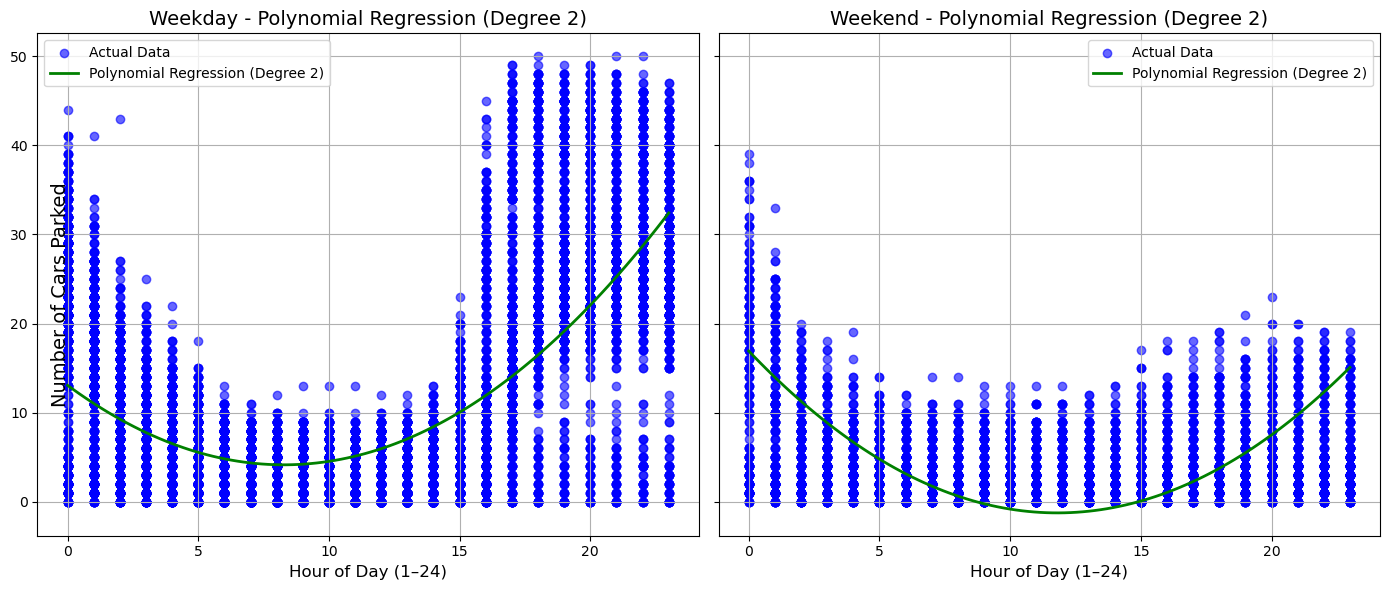

In [22]:
x_b_train, x_b_test, y_b_train, y_b_test = train_test_split(x_b, y_b, test_size=0.5, random_state=42)

# Create polynomial features with degree 2
poly = PolynomialFeatures(degree=2)

# Transform the Hour and isWeekday features together
x_train_poly = poly.fit_transform(x_b_train)  # Polynomial transform for both features
x_test_poly = poly.transform(x_b_test)  # Apply the same transformation to the test set

# Train a single polynomial regression model (Linear Regression on transformed features)
model_b_poly = LinearRegression()
model_b_poly.fit(x_train_poly, y_b_train)

# Predictions for smooth curve
X_grid = np.linspace(min(x_b[:, 0]), max(x_b[:, 0]), 100).reshape(-1, 1)

# Create a combined feature array where isWeekday is set to 1 for weekdays and 0 for weekends
X_grid_weekday = np.hstack([X_grid, np.ones_like(X_grid)])  # Set isWeekday to 1 (weekday)
X_grid_weekend = np.hstack([X_grid, np.zeros_like(X_grid)])  # Set isWeekday to 0 (weekend)

X_grid_poly_weekday = poly.transform(X_grid_weekday)  # Apply polynomial transformation
X_grid_poly_weekend = poly.transform(X_grid_weekend)

y_grid_weekday = model_b_poly.predict(X_grid_poly_weekday)  # Predictions for weekdays
y_grid_weekend = model_b_poly.predict(X_grid_poly_weekend)  # Predictions for weekends

# Subplots for weekday and weekend
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for ax, title, is_weekday, y_grid in zip(axes,
    ["Weekday", "Weekend"],
    [1, 0],
    [y_grid_weekday, y_grid_weekend]):
    
    # Filter data for weekday or weekend
    x_data = x_b[x_b[:, 1] == is_weekday]
    y_data = y_b[x_b[:, 1] == is_weekday]

    # Scatter plot of actual data
    ax.scatter(x_data[:, 0], y_data, color='blue', label='Actual Data', alpha=0.6)

    # Polynomial regression line
    ax.plot(X_grid, y_grid, color='green', label='Polynomial Regression (Degree 2)', linewidth=2)

    # Titles and labels
    ax.set_title(f'{title} - Polynomial Regression (Degree 2)', fontsize=14)
    ax.set_xlabel('Hour of Day (1–24)', fontsize=12)
    ax.grid(True)
    ax.legend()

# Shared y-label
fig.text(0.04, 0.5, 'Number of Cars Parked', va='center', rotation='vertical', fontsize=14)

plt.tight_layout()
plt.show()

Random Forest Regression

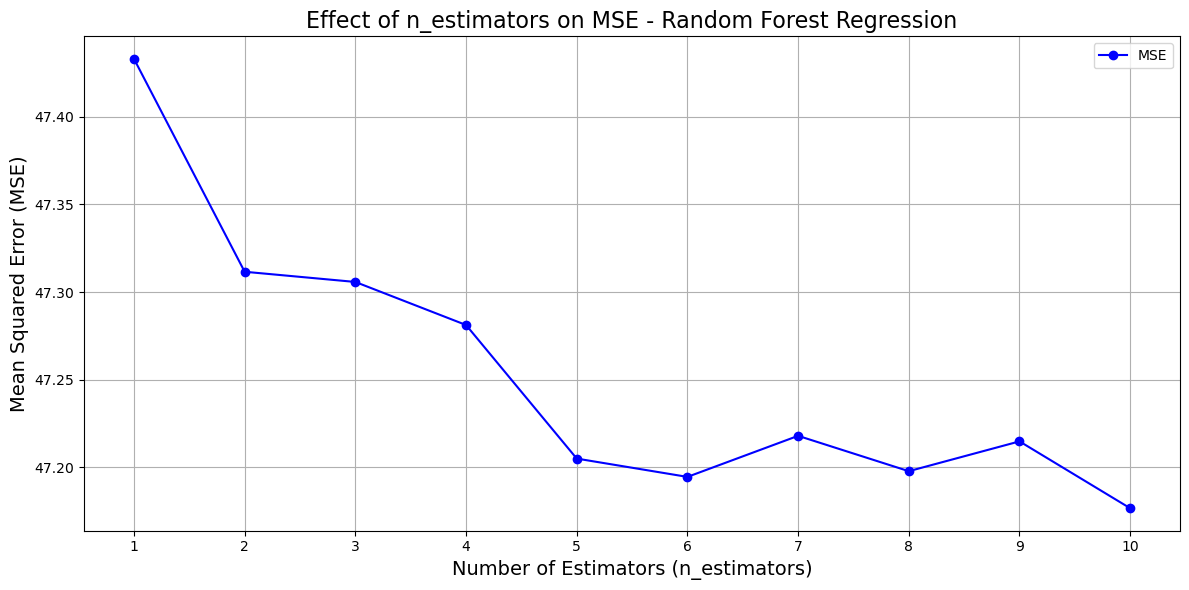

In [23]:

# Split the data into training and testing sets
x_b_train, x_b_test, y_b_train, y_b_test = train_test_split(x_b, y_b, test_size=0.5, random_state=42)

# Initialize lists to store the results
n_estimators_range = range(1, 11, 1)
mse_values = []

# Loop through the range of n_estimators
for n_estimators in n_estimators_range:
    # Create and fit the RandomForestRegressor model
    model_b_rf = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
    model_b_rf.fit(x_b_train, y_b_train)
    
    # Make predictions
    y_b_pred = model_b_rf.predict(x_b_test)
    
    # Calculate Mean Squared Error
    mse = mean_squared_error(y_b_test, y_b_pred)
    mse_values.append(mse)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(n_estimators_range, mse_values, marker='o', linestyle='-', color='blue', label='MSE')
plt.title('Effect of n_estimators on MSE - Random Forest Regression', fontsize=16)
plt.xlabel('Number of Estimators (n_estimators)', fontsize=14)
plt.ylabel('Mean Squared Error (MSE)', fontsize=14)
plt.xticks(n_estimators_range)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

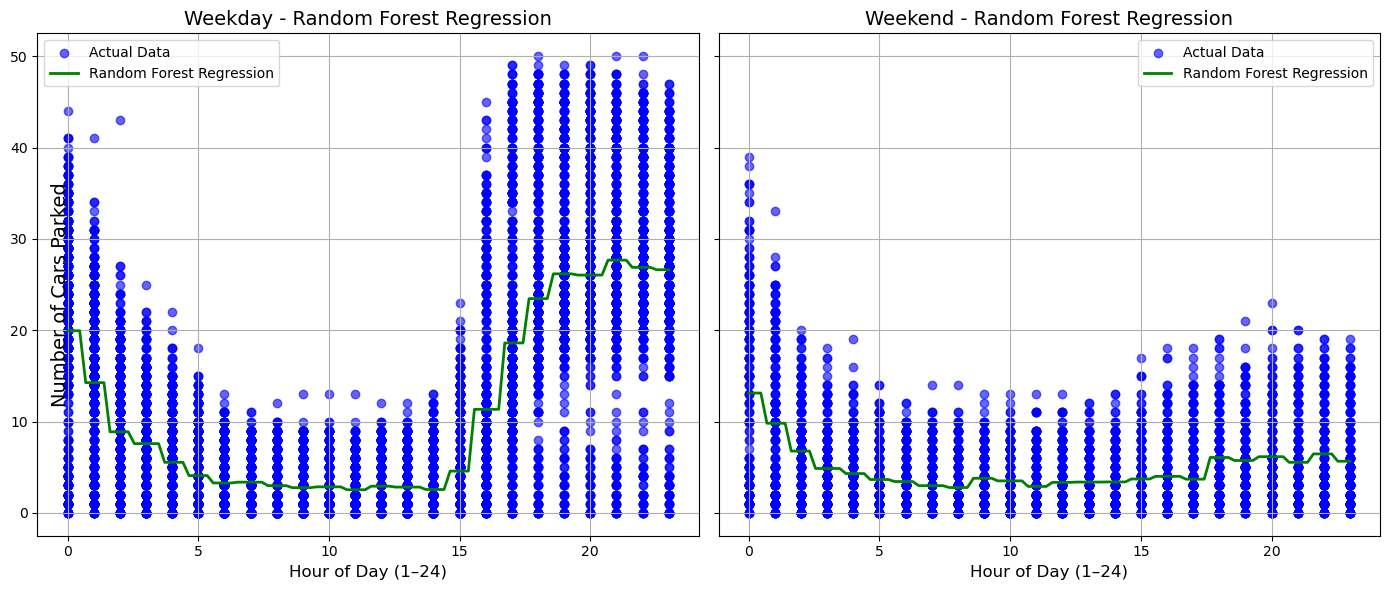

In [24]:
# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_b, y_b, test_size=0.5, random_state=42)

# Train a single Random Forest model with both features (Hour and isWeekday)
model_b_rf = RandomForestRegressor(n_estimators=1, random_state=42)  # You can adjust n_estimators as needed
model_b_rf.fit(x_train, y_train)

# Predictions for smooth curve
X_grid = np.linspace(min(x_b[:, 0]), max(x_b[:, 0]), 100).reshape(-1, 1)
X_grid_combined = np.hstack([X_grid, np.ones_like(X_grid) * x_b[0, 1]])  # Add the isWeekday feature
y_grid = model_b_rf.predict(X_grid_combined)

# Subplots for weekday and weekend
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for ax, title, is_weekday in zip(axes, ["Weekday", "Weekend"], [1, 0]):
    # Filter data for weekday or weekend
    x_data = x_b[x_b[:, 1] == is_weekday]
    y_data = y_b[x_b[:, 1] == is_weekday]

    # Scatter plot of actual data
    ax.scatter(x_data[:, 0], y_data, color='blue', label='Actual Data', alpha=0.6)

    # Random Forest regression line
    X_grid_combined = np.hstack([X_grid, np.ones_like(X_grid) * is_weekday])  # Update for weekday/weekend
    y_grid = model_b_rf.predict(X_grid_combined)
    ax.plot(X_grid, y_grid, color='green', label='Random Forest Regression', linewidth=2)

    # Titles and labels
    ax.set_title(f'{title} - Random Forest Regression', fontsize=14)
    ax.set_xlabel('Hour of Day (1–24)', fontsize=12)
    ax.grid(True)
    ax.legend()

# Shared y-label
fig.text(0.04, 0.5, 'Number of Cars Parked', va='center', rotation='vertical', fontsize=14)

plt.tight_layout()
plt.show()

Neural Network

In [ ]:
def build_and_train_nn(x_data, y_data):
    # Standardize the features: scale both 'time' and 'isWeekday'
    scaler = StandardScaler()
    x_data_scaled = scaler.fit_transform(x_data)  # Scale both features together

    # Split data into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(x_data_scaled, y_data, test_size=0.5, random_state=42)

    # Build the neural network model
    model = Sequential()
    model.add(Dense(512, input_dim=2, activation='relu'))  # Input layer and first hidden layer (2 features)
    model.add(Dropout(0.3))  # Dropout layer
    model.add(Dense(256, activation='relu'))  # Second hidden layer
    model.add(Dropout(0.3))  # Dropout layer
    model.add(Dense(128, activation='relu'))  # Third hidden layer
    model.add(Dropout(0.3))  # Dropout layer
    model.add(Dense(64, activation='relu'))  # Fourth hidden layer
    model.add(Dense(1, activation='linear'))  # Output layer

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

    # Train the model
    model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test), verbose=0)

    # Evaluate the model
    test_loss, test_mae = model.evaluate(x_test, y_test, verbose=0)

    # Predictions for smooth grid
    X_grid = np.linspace(min(x_data[:, 0]), max(x_data[:, 0]), 100).reshape(-1, 1)
    X_grid_combined = np.hstack([X_grid, np.ones_like(X_grid) * x_data[0, 1]])  # Combine time and 'isWeekday' for predictions
    X_grid_scaled = scaler.transform(X_grid_combined)  # Scale both features together
    y_grid = model.predict(X_grid_scaled)

    return X_grid, y_grid, test_loss, test_mae, model, scaler

# Train the model on the combined data
X_grid, y_grid, test_loss, test_mae, model_b_neuro, scaler = build_and_train_nn(x_b, y_b)

# Subplots for weekday and weekend
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for ax, title, is_weekday in zip(
    axes, 
    ["Weekday", "Weekend"],
    [1, 0]
):
    x_data = x_b[x_b[:, 1] == is_weekday]
    y_data = y_b[x_b[:, 1] == is_weekday]
    # Scatter plot of actual data
    ax.scatter(x_data[:, 0], y_data, color='blue', label='Actual Data', alpha=0.6)

    # Prepare the grid for predictions
    X_grid_combined = np.hstack([X_grid, np.ones_like(X_grid) * x_data[0, 1]])  # Keep isWeekday value for the current subset
    X_grid_scaled = scaler.transform(X_grid_combined)  # Scale both time and isWeekday features
    
    # Make predictions for the smooth grid
    y_grid = model_b_neuro.predict(X_grid_scaled)
    
    # Plot the neural network predictions
    ax.plot(X_grid[:, 0], y_grid, color='red', label='NN Predictions', linewidth=2)

    # Titles and labels
    ax.set_title(f'{title} - NN Predictions\nMSE: {test_loss:.2f}, MAE: {test_mae:.2f}', fontsize=14)
    ax.set_xlabel('Hour of Day (1–24)', fontsize=12)
    ax.grid(True)
    ax.legend()

# Shared y-label
fig.text(0.04, 0.5, 'Number of Cars Parked', va='center', rotation='vertical', fontsize=14)

plt.tight_layout()
plt.show()

4/4 [==============================] - 0s 3ms/step


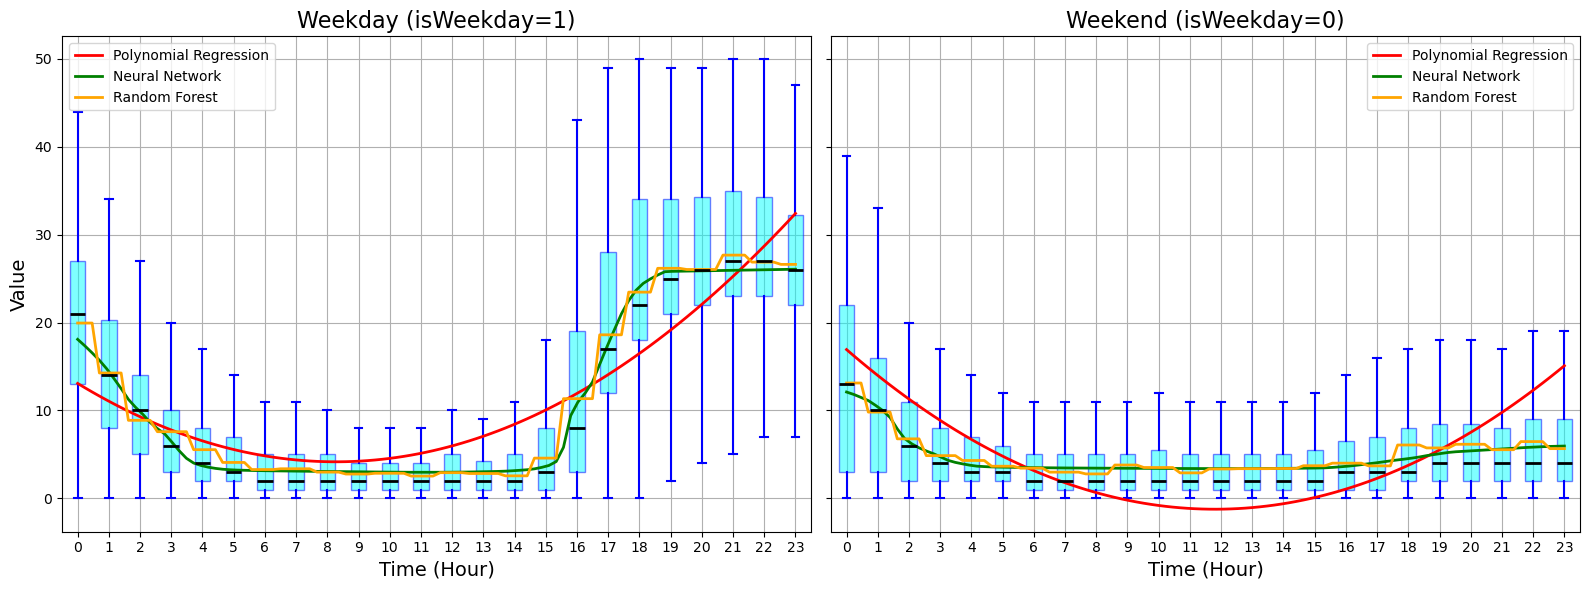

In [ ]:
# Split data into weekday (isWeekday=1) and weekend (isWeekday=0)
x_weekday = x_b[x_b[:, 1] == 1]
y_weekday = y_b[x_b[:, 1] == 1]
x_weekend = x_b[x_b[:, 1] == 0]
y_weekend = y_b[x_b[:, 1] == 0]

# Create smooth grids for prediction with the addition of the isWeekday feature
time_grid_weekday = np.linspace(min(x_weekday[:, 0]), max(x_weekday[:, 0]), 100).reshape(-1, 1)
X_grid_weekday = np.hstack([time_grid_weekday, np.ones_like(time_grid_weekday)])  # Add isWeekday=1

time_grid_weekend = np.linspace(min(x_weekend[:, 0]), max(x_weekend[:, 0]), 100).reshape(-1, 1)
X_grid_weekend = np.hstack([time_grid_weekend, np.zeros_like(time_grid_weekend)])  # Add isWeekday=0

# Ensure the correct shape
X_grid_weekday_neuro = np.hstack([time_grid_weekday, np.ones_like(time_grid_weekday)])  # (100, 2)
X_grid_weekend_neuro = np.hstack([time_grid_weekend, np.zeros_like(time_grid_weekend)])  # (100, 2)

# If feature scaling was used during training, apply the same scaling
X_grid_weekday_scaled_neuro = scaler.transform(X_grid_weekday)  # Use the same scaler as during training
X_grid_weekend_scaled_neuro = scaler.transform(X_grid_weekend)

# Predict using the correctly transformed inputs
y_grid_neuro_weekday = model_b_neuro.predict(X_grid_weekday_scaled_neuro)
y_grid_neuro_weekend = model_b_neuro.predict(X_grid_weekend_scaled_neuro)


# Predictions for weekday
y_grid_poly_weekday = model_b_poly.predict(poly.transform(X_grid_weekday))
y_grid_rf_weekday = model_b_rf.predict(X_grid_weekday)

# Predictions for weekend
y_grid_poly_weekend = model_b_poly.predict(poly.transform(X_grid_weekend))
y_grid_rf_weekend = model_b_rf.predict(X_grid_weekend)

# Create the plots
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Weekday boxplot and predictions
unique_hours_weekday = np.unique(x_weekday[:, 0])
data_for_boxplot_weekday = [y_weekday[x_weekday[:, 0] == hour] for hour in unique_hours_weekday]

axs[0].boxplot(
    data_for_boxplot_weekday,
    positions=unique_hours_weekday,
    widths=0.5,
    patch_artist=True,
    boxprops=dict(facecolor='cyan', color='blue', alpha=0.5),
    medianprops=dict(color='black', linewidth=2),
    whiskerprops=dict(color='blue', linewidth=1.5),
    capprops=dict(color='blue', linewidth=1.5),
    showfliers=False,
)
axs[0].plot(X_grid_weekday[:, 0], y_grid_poly_weekday, color='red', label='Polynomial Regression', linewidth=2)
axs[0].plot(X_grid_weekday[:, 0], y_grid_neuro_weekday, color='green', label='Neural Network', linewidth=2)
axs[0].plot(X_grid_weekday[:, 0], y_grid_rf_weekday, color='orange', label='Random Forest', linewidth=2)
axs[0].set_title('Weekday (isWeekday=1)', fontsize=16)
axs[0].set_xlabel('Time (Hour)', fontsize=14)
axs[0].set_ylabel('Value', fontsize=14)
axs[0].grid(True)
axs[0].legend()

# Weekend boxplot and predictions
unique_hours_weekend = np.unique(x_weekend[:, 0])
data_for_boxplot_weekend = [y_weekend[x_weekend[:, 0] == hour] for hour in unique_hours_weekend]

axs[1].boxplot(
    data_for_boxplot_weekend,
    positions=unique_hours_weekend,
    widths=0.5,
    patch_artist=True,
    boxprops=dict(facecolor='cyan', color='blue', alpha=0.5),
    medianprops=dict(color='black', linewidth=2),
    whiskerprops=dict(color='blue', linewidth=1.5),
    capprops=dict(color='blue', linewidth=1.5),
    showfliers=False,
)
axs[1].plot(X_grid_weekend[:, 0], y_grid_poly_weekend, color='red', label='Polynomial Regression', linewidth=2)
axs[1].plot(X_grid_weekend[:, 0], y_grid_neuro_weekend, color='green', label='Neural Network', linewidth=2)
axs[1].plot(X_grid_weekend[:, 0], y_grid_rf_weekend, color='orange', label='Random Forest', linewidth=2)
axs[1].set_title('Weekend (isWeekday=0)', fontsize=16)
axs[1].set_xlabel('Time (Hour)', fontsize=14)
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()

C:\Users\vigro\AppData\Local\Temp\ipykernel_27496\3276957828.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='time', y='utilization', data=weekday_data, palette='Blues', ax=axes[0])
C:\Users\vigro\AppData\Local\Temp\ipykernel_27496\3276957828.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='time', y='utilization', data=weekend_data, palette='Blues', ax=axes[1])


4/4 [==============================] - 0s 2ms/step


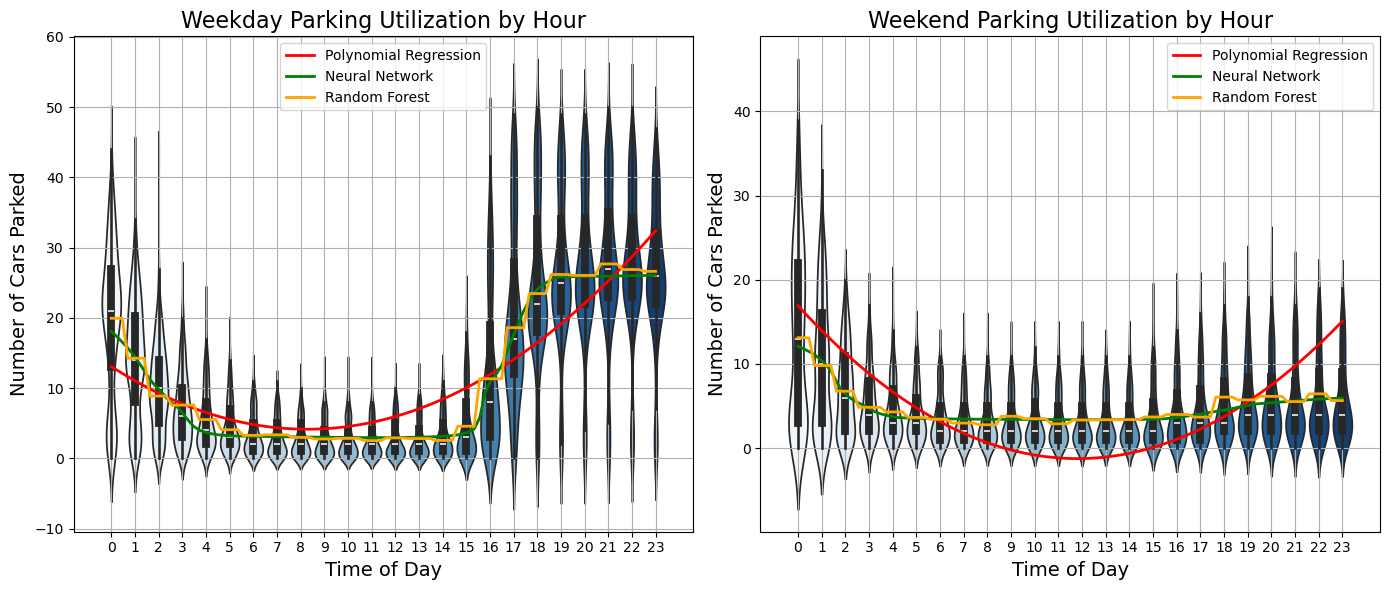

In [ ]:
# Filter the data based on isWeekday
weekday_data = utilization_b[utilization_b['isWeekday'] == 1]
weekend_data = utilization_b[utilization_b['isWeekday'] == 0]

# Set up the figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot violin plots
sns.violinplot(x='time', y='utilization', data=weekday_data, palette='Blues', ax=axes[0])
sns.violinplot(x='time', y='utilization', data=weekend_data, palette='Blues', ax=axes[1])

# Generate smooth time values
time_range = np.linspace(0, 23, 100).reshape(-1, 1)  # Assuming time is in hours

# Prepare feature matrix for regression models
X_grid_weekday = np.hstack([time_range, np.ones_like(time_range)])  # [time, isWeekday=1]
X_grid_weekend = np.hstack([time_range, np.zeros_like(time_range)])  # [time, isWeekday=0]

# Apply transformations if necessary
X_grid_weekday_poly = poly.transform(X_grid_weekday)  # For polynomial model
X_grid_weekend_poly = poly.transform(X_grid_weekend)

# Make predictions
y_grid_poly_weekday = model_b_poly.predict(X_grid_weekday_poly)
y_grid_poly_weekend = model_b_poly.predict(X_grid_weekend_poly)

y_grid_neuro_weekday = model_b_neuro.predict(scaler.transform(X_grid_weekday))
y_grid_neuro_weekend = model_b_neuro.predict(scaler.transform(X_grid_weekend))

y_grid_rf_weekday = model_b_rf.predict(X_grid_weekday)
y_grid_rf_weekend = model_b_rf.predict(X_grid_weekend)

# Plot regression lines
axes[0].plot(time_range, y_grid_poly_weekday, color='red', label='Polynomial Regression', linewidth=2)
axes[0].plot(time_range, y_grid_neuro_weekday, color='green', label='Neural Network', linewidth=2)
axes[0].plot(time_range, y_grid_rf_weekday, color='orange', label='Random Forest', linewidth=2)

axes[1].plot(time_range, y_grid_poly_weekend, color='red', label='Polynomial Regression', linewidth=2)
axes[1].plot(time_range, y_grid_neuro_weekend, color='green', label='Neural Network', linewidth=2)
axes[1].plot(time_range, y_grid_rf_weekend, color='orange', label='Random Forest', linewidth=2)

# Set titles and labels
axes[0].set_title('Weekday Parking Utilization by Hour', fontsize=16)
axes[1].set_title('Weekend Parking Utilization by Hour', fontsize=16)
for ax in axes:
    ax.set_xlabel('Time of Day', fontsize=14)
    ax.set_ylabel('Number of Cars Parked', fontsize=14)
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()